# Big data parallel programming 2020
### Project Description

In order to pass the course you need to complete this project. You need to produce a program, write a report and make a presentation. You have to work individually for the assigned task. The aim of the project is for you to get some experience with applying the techniques you have learned about spark in a more open-ended setting. This is a good practice since it allows you to verify your understanding of the methods in practice and receive feedback on it.

We encourage you to propose your own idea for the final project. If you have your own idea, you need to discuss it with us in order to decide whether your idea is suitable for a project in this course. We encourage machine learning/data mining projects, although other ideas may also get accepted.
You should email a short description by `April 22nd` to `mahmoud.rahat@hh.se`. We will then give you feedback on the idea and further instructions.

In any case the project has to satisfy the following requirements:
1. The program has to be written using `Apache Spark framework,` and a significant portion of the code/computations needs to run in parallel.
1. The program has to run on the cloud platform e.g, `Google cloud` or `IBM Watson studio`.
1. The results from the program can be displayed or stored in a file in the cloud.

__Notice:__ Although the general idea of Spark is to abstract away the scale of the data from the programmer, it is still a big plus if you demonstrate your project on a large amount of data.

Some data sources that can be used to generate data, and you might want to consider in your project are:
- Youtube videos from https://developers.google.com/youtube/v3/docs/videos
- Data collected by Wikimedia from their dierent projects (among them the wikipedia)
https://meta.wikimedia.org/wiki/Research:Data
- Books from the Gutenberg project http://www.gutenberg.org/
- Human activity data
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

#### Teacher's suggestion for a project
In case you do not have an idea of your own for a project you can always do this one.

You are given a dataset called `data/ccdefault.csv`. The dataset represents default of credit card clients. It has 30,000 cases and 24 different attributes. More details about the dataset is available at `data/ccdefault.txt`. In this task you should make three models, compare their results and conclude the ideal solution. Here are the suggested steps:
1. Load the data.
2. Carry out some exploratory analyses (e.g., how various features and the target variable are distributed).
3. Train a model to predict the target variable (risk of `default`).
  - Employ three different models (logistic regression, decision tree, and random forest).
  - Compare the models' performances (e.g., AUC).
  - Defend your choice of best model (e.g., what are the strength and weaknesses of each of these models?).
4. What more would you do with this data? Anything to help you devise a better solution e.g., feature selection/extraction/engineering?

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('Spark Project')
sc = SparkContext(conf=conf)
sc

<SparkContext master=local[*] appName=Spark Project>

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Spark Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [4]:
import numpy as np
from matplotlib import pyplot as plt

In [5]:
rawDataTrain = spark.read.load("data/drugsComTrain_raw.tsv",format="csv", sep="\t", inferSchema="true", header="true")
rawDataTest = spark.read.load("data/drugsComTest_raw.tsv",format="csv", sep="\t", inferSchema="true", header="true")
rawData = rawDataTrain.unionByName(rawDataTest)
rawData.take(2)

[Row(id='206461', drugName='Valsartan', condition='Left Ventricular Dysfunction', review='"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"""', rating='9.0', date='May 20, 2012', usefulCount=27),
 Row(id='95260', drugName='Guanfacine', condition='ADHD', review='"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. ', rating=None, date=None, usefulCount=None)]

In [6]:
rawData.printSchema()

root
 |-- id: string (nullable = true)
 |-- drugName: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- review: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- date: string (nullable = true)
 |-- usefulCount: integer (nullable = true)



In [7]:
print("Rows in Train: ", rawDataTrain.count())
print("Rows in Test: ", rawDataTest.count())
print("Total Rows: ", rawData.count())

Rows in Train:  197054
Rows in Test:  65987
Total Rows:  263041


## Count the missing data

In [8]:
from pyspark.sql.functions import when, count, col

rawData.select([count(when(col(c).isNull(), c)).alias(c) for c in rawData.columns]).show()

+---+--------+---------+------+------+-----+-----------+
| id|drugName|condition|review|rating| date|usefulCount|
+---+--------+---------+------+------+-----+-----------+
|  2|   23896|    25112| 23922| 72027|72034|      72034|
+---+--------+---------+------+------+-----+-----------+



## Remove rows with missing data
I remove the rows with missing data since it's impossiple to interpolate this data.

In [9]:
USEFUL_COLS = ("drugName", "condition", "review", "rating")
filteredData = rawData.dropna(subset=USEFUL_COLS)

In [11]:
filteredData.select([count(when(col(c).isNull(), c)).alias(c) for c in rawData.columns]).show()

+---+--------+---------+------+------+----+-----------+
| id|drugName|condition|review|rating|date|usefulCount|
+---+--------+---------+------+------+----+-----------+
|  2|       0|        0|     0|     0|   7|          7|
+---+--------+---------+------+------+----+-----------+



There's still two rows with missing data in `date` and `usefulCount` but since i dont use these it's ok.

In [12]:
filteredData.count()

189918

## Start of analysis

In [13]:
print("Number of diffrent drugs: ", filteredData.select("drugName").distinct().count())
print("Number of diffrent conditions: ", filteredData.select("condition").distinct().count())

Number of diffrent drugs:  3576
Number of diffrent conditions:  900


### How many times has each drug been prescribed?

In [14]:
filteredData.groupBy("drugName").count().orderBy("count", ascending=False).show(truncate=False)

+----------------------------------+-----+
|drugName                          |count|
+----------------------------------+-----+
|Levonorgestrel                    |4332 |
|Etonogestrel                      |3944 |
|Ethinyl estradiol / norethindrone |3282 |
|Nexplanon                         |2579 |
|Ethinyl estradiol / norgestimate  |2424 |
|Ethinyl estradiol / levonorgestrel|2186 |
|Phentermine                       |1864 |
|Sertraline                        |1573 |
|Escitalopram                      |1514 |
|Mirena                            |1455 |
|Implanon                          |1361 |
|Gabapentin                        |1226 |
|Miconazole                        |1203 |
|Bupropion                         |1179 |
|Medroxyprogesterone               |1167 |
|Venlafaxine                       |1164 |
|Citalopram                        |1152 |
|Lexapro                           |1118 |
|Duloxetine                        |1099 |
|Metronidazole                     |1070 |
+----------

### How many times has each drug been prescribed given a condition?
A drug can be used to more than one condition.

In [15]:
filteredData.groupBy("drugName", "condition").count().orderBy("count", ascending=False).show(10, truncate=False)

+----------------------------------+-----------------------+-----+
|drugName                          |condition              |count|
+----------------------------------+-----------------------+-----+
|Etonogestrel                      |Birth Control          |3937 |
|Ethinyl estradiol / norethindrone |Birth Control          |2787 |
|Nexplanon                         |Birth Control          |2573 |
|Levonorgestrel                    |Birth Control          |2521 |
|Ethinyl estradiol / levonorgestrel|Birth Control          |1921 |
|Ethinyl estradiol / norgestimate  |Birth Control          |1905 |
|Levonorgestrel                    |Emergency Contraception|1499 |
|Phentermine                       |Weight Loss            |1488 |
|Implanon                          |Birth Control          |1351 |
|Miconazole                        |Vaginal Yeast Infection|1201 |
+----------------------------------+-----------------------+-----+
only showing top 10 rows



## Reduce the dataset

At this step I reduce the dataset by combining the reviews and ratings of each group of (drug, condition).

I also calculate the average review rating, standrad deviation of the revies and the number of reviews.

In [16]:
import pyspark.sql.functions as f
groupedReviews = filteredData.groupBy("drugName", "condition").agg(f.concat_ws("", f.collect_list(filteredData.review)).alias("review"))

In [17]:
groupedRatings = filteredData.groupBy("drugName", "condition").agg(f.concat(f.collect_list(filteredData.rating)).alias("rating"))

In [18]:
groupedNumReviews = filteredData.groupBy("drugName", "condition").agg(f.size(f.collect_list(filteredData.rating)).alias("num_reviews"))

In [19]:
groupedAVG = filteredData.groupBy("drugName", "condition").agg(f.avg(f.concat(filteredData.rating)).alias("avg"))

In [20]:
groupedSTD = filteredData.groupBy("drugName", "condition").agg(f.stddev(f.concat(filteredData.rating)).alias("std"))

In [21]:
groupedReviews.createOrReplaceTempView("groupedReviews")
groupedRatings.createOrReplaceTempView("groupedRatings")
groupedData = spark.sql("""SELECT groupedReviews.drugName, groupedReviews.condition, groupedReviews.review, groupedRatings.rating FROM groupedReviews 
                            JOIN groupedRatings ON groupedReviews.drugName == groupedRatings.drugName AND groupedReviews.condition == groupedRatings.condition""")

#groupedData.show(5)

In [22]:
groupedNumReviews.createOrReplaceTempView("groupedNumReviews")
groupedData.createOrReplaceTempView("groupedData")

groupedData = spark.sql("""SELECT groupedData.drugName, groupedData.condition, groupedData.review, groupedData.rating, groupedNumReviews.num_reviews FROM groupedData 
                            JOIN groupedNumReviews ON groupedData.drugName == groupedNumReviews.drugName AND groupedData.condition == groupedNumReviews.condition""")

In [23]:
groupedSTD.createOrReplaceTempView("groupedSTD")
groupedData.createOrReplaceTempView("groupedData")

groupedData = spark.sql("""SELECT groupedData.drugName, groupedData.condition, groupedData.review, groupedData.rating, groupedData.num_reviews, groupedSTD.std FROM groupedData 
                            JOIN groupedSTD ON groupedData.drugName == groupedSTD.drugName AND groupedData.condition == groupedSTD.condition""")
#groupedData.show(5)

In [24]:
groupedAVG.createOrReplaceTempView("groupedAVG")
groupedData.createOrReplaceTempView("groupedData")

groupedData = spark.sql("""SELECT groupedData.drugName, groupedData.condition, groupedData.review, groupedData.rating, groupedData.num_reviews, groupedAVG.avg, groupedData.std FROM groupedData 
                            JOIN groupedAVG ON groupedData.drugName == groupedAVG.drugName AND groupedData.condition == groupedAVG.condition""")
groupedData.show(1)

+--------+---------+--------------------+--------------------+-----------+---+-----------------+
|drugName|condition|              review|              rating|num_reviews|avg|              std|
+--------+---------+--------------------+--------------------+-----------+---+-----------------+
|Absorica|     Acne|"""I&rsquo;m a 23...|[10.0, 1.0, 4.0, ...|          4|6.0|4.242640687119285|
+--------+---------+--------------------+--------------------+-----------+---+-----------------+
only showing top 1 row



In [25]:
from pyspark.sql.types import StringType, ArrayType, IntegerType
import pyspark.sql.functions as f

# Remove the unwanted characters
def process(col):
    bad_words = ("&amp;", "&lt;", "&gt;")
    temp = col.replace("&quot;", '"').replace("&rsquo;", "'").replace("&#039;", "'")
    for word in bad_words:
        temp = temp.replace(word, " ")
    return temp

process_udf = f.udf(process, StringType())
processedReview = groupedData.withColumn("review_processed", process_udf("review"))
#processedReview.show(2, truncate=False, vertical=True)

## Tokenize

Tokenize every review, it splits on and removes every space and special character except ' and -. The tokenize_split just splits on """ which is the separator between reviews.
The Stop Words Remover removes every stop word to reduce the data.

In [83]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.ml import Pipeline

tokenize = RegexTokenizer(pattern="(\s)|([^\w\s'-])", inputCol="review_processed", outputCol="review_tokenized", toLowercase=True)
tokenize_split = RegexTokenizer(pattern='(""")', inputCol="review_processed", outputCol="review_split", toLowercase=False)
swr = StopWordsRemover(inputCol="review_tokenized", outputCol="review_WO_stop")

pipe = Pipeline(stages=[tokenize, tokenize_split, swr])
noSWData = pipe.fit(processedReview).transform(processedReview)
#noSWData.show(2, truncate=False, vertical=True)

### Lemmatizing
This tranforms every word to its original form (the dictionary form) by using the NLTK libraray. To get the most out of the NLTK lemmatizer you have to tag every word with the correct class, i.e. POS (Part-of-Speech) tagging.



__IMPORTANT__ There is a wierd bug, to run this you have to execute this cell **3** Times!!


In [84]:
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from collections import defaultdict

## UNCOMMENT THIS THE FIRST TIME YOU RUN THIS CODE
# from nltk import download
# download('wordnet')
# download('averaged_perceptron_tagger')
# download('omw')


def lemmatizeWords(review):
    # def tag_filter(word):
    #     if word[1][0] in ["N", "R", "V"]:
    #         return True
    #     else:
    #         return False
    
    wnl = WordNetLemmatizer() # Init the lemmatizer
    cleaned = [word.replace(".", "").replace(",", "") for word in review] # Remove any chars which the Tokenizer doesn't remove
    cleaned = list(filter(None,cleaned)) # Remove all the None elements
    tagged_words = pos_tag(cleaned) # POS-tag every word
    # Since the tags from the POS_tagger doesn't work with the lemmatizer we have to translate them.
    #tagged_words_filtered = list(filter(tag_filter, tagged_words))
    newTags = defaultdict(lambda : wordnet.NOUN)
    newTags["R"] = wordnet.ADV
    newTags["V"] = wordnet.VERB
    newTags["J"] = wordnet.ADJ
    rev = [wnl.lemmatize(word[0], newTags[word[1][0]]) for word in tagged_words] # lemmatizez every word
    return rev

lemmatize_udf = f.udf(lemmatizeWords, ArrayType(StringType())) # init the lemmatizer UDF function

lemmatizedData = noSWData.withColumn("review_lemmatized", lemmatize_udf("review_WO_stop")) # Process the UDF function on the column
lemmatizedData.select("*").where(col("num_reviews")==2).show(2, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 drugName          | Aluminum hydroxide / magnesium hydroxide / simethicone                                                                                                                                                                                                                                                                                                         

Now we can see how reviews look after they have been processed versus the original form.

## Create Bigrams of the lemmatized words

In [85]:
from pyspark.ml.feature import NGram

ngrammer = NGram(n = 2, inputCol="review_lemmatized", outputCol="ngrams")
nGramLemmatizedData = ngrammer.transform(lemmatizedData)
nGramLemmatizedData = nGramLemmatizedData.drop("review", "review_tokenized", "review_WO_stop", "review_lemmatized")
nGramLemmatizedData = nGramLemmatizedData.withColumn("id", f.monotonically_increasing_id())
#nGramLemmatizedData.select("*").where(col("num_reviews")==2).show(2, truncate=False, vertical=True)

## Word frequency of every Bigram in the review

In [86]:
countedData = nGramLemmatizedData.select("id", f.explode("ngrams").alias("ngrams")).groupBy("id","ngrams").count().orderBy("count", ascending=False)
countedData = countedData.groupBy("id").agg(f.arrays_zip(f.collect_list("ngrams"), f.collect_list("count")).alias("ngram_word_frequency"))



nGramLemmatizedData.createOrReplaceTempView("nGramLemmatizedData")
countedData.createOrReplaceTempView("countedData")
wfData = spark.sql("""SELECT nGramLemmatizedData.id, nGramLemmatizedData.drugName, nGramLemmatizedData.condition, nGramLemmatizedData.rating, nGramLemmatizedData.review_split, nGramLemmatizedData.num_reviews, nGramLemmatizedData.avg, nGramLemmatizedData.std, countedData.ngram_word_frequency 
                            FROM nGramLemmatizedData 
                            JOIN countedData ON nGramLemmatizedData.id == countedData.id""")
#wfData.select("*").where(col("num_reviews")==5).show(2, truncate=False, vertical=True)

## Sentiment analysis

In [87]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.types import DoubleType

# from nltk import download
# download('vader_lexicon')

# Sentiment for every ngram in the review
def getSentimentNGrams(reviews):
    senti = SentimentIntensityAnalyzer()
    sentiments = [(ngram[0], ngram[1], round(senti.polarity_scores(ngram[0])["compound"], 4)) for ngram in reviews] 
    return sentiments

# Sentiment for the whole review
def getSentimentReview(reviews):
    senti = SentimentIntensityAnalyzer()
    return [round(senti.polarity_scores(review)["compound"], 4) for review in reviews]

getSentimentReview_udf = f.udf(getSentimentReview, ArrayType(DoubleType()))
getSentimentNGrams_udf = f.udf(getSentimentNGrams, ArrayType(ArrayType(StringType())))


sentimentData = wfData.withColumn("ngram_sentiment_compunds", getSentimentNGrams_udf("ngram_word_frequency"))
sentimentData = sentimentData.withColumn("review_sentiment", getSentimentReview_udf("review_split"))
#sentimentData.select("*").where(col("num_reviews")==2).show(1, truncate=False, vertical=True)

In [88]:
from wordcloud import WordCloud


#wordFreq = finalFrame.select("ngram_word_frequency", "drugName", "condition", "num_reviews", "avg", "std").where(col("num_reviews") == 10).take(5)
wordFreq = sentimentData.select("ngram_sentiment_compunds", "drugName", "condition", "num_reviews", "avg", "std", "review_sentiment").orderBy(col("num_reviews"), ascending=False).take(10)


<Figure size 432x288 with 0 Axes>

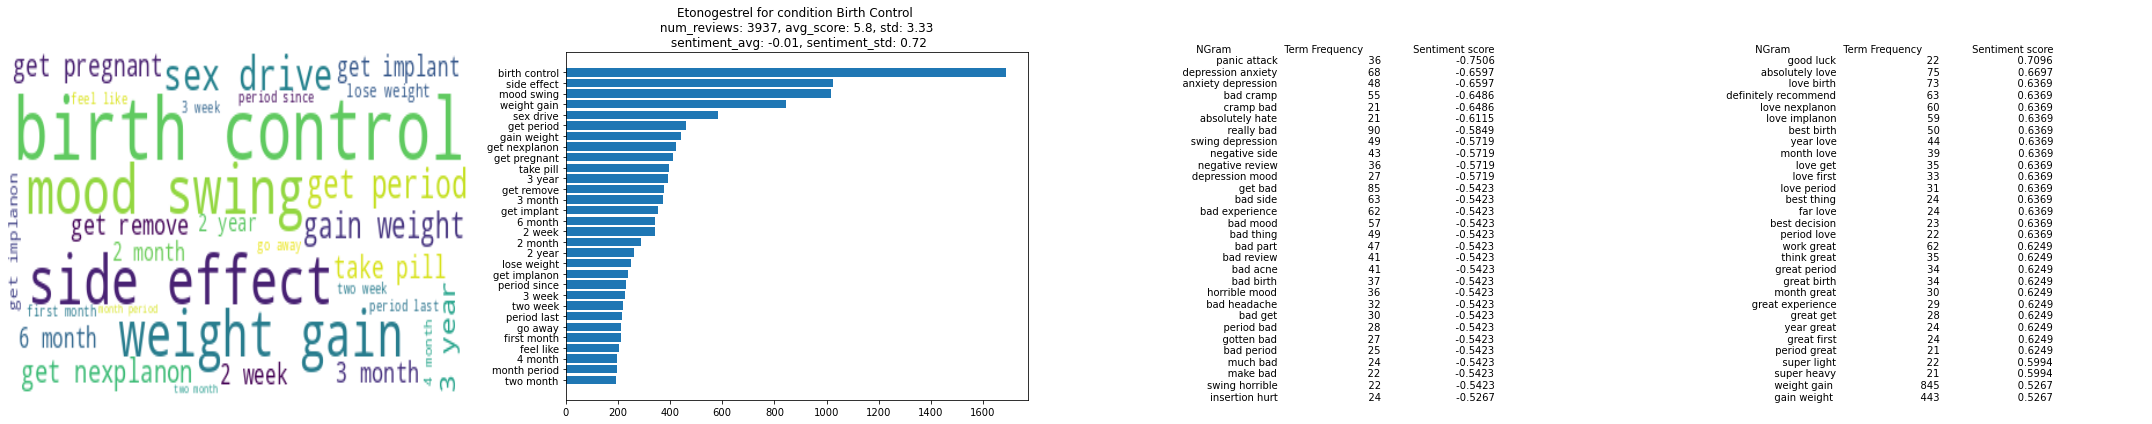

<Figure size 432x288 with 0 Axes>

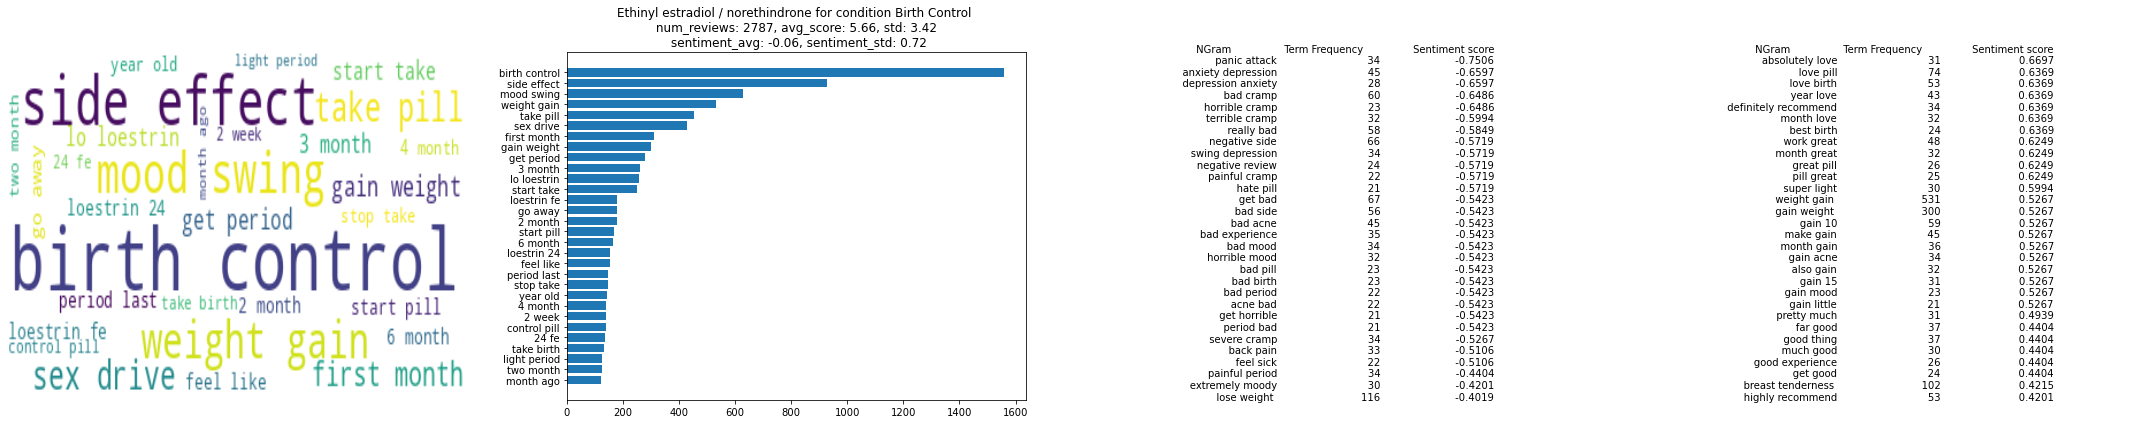

<Figure size 432x288 with 0 Axes>

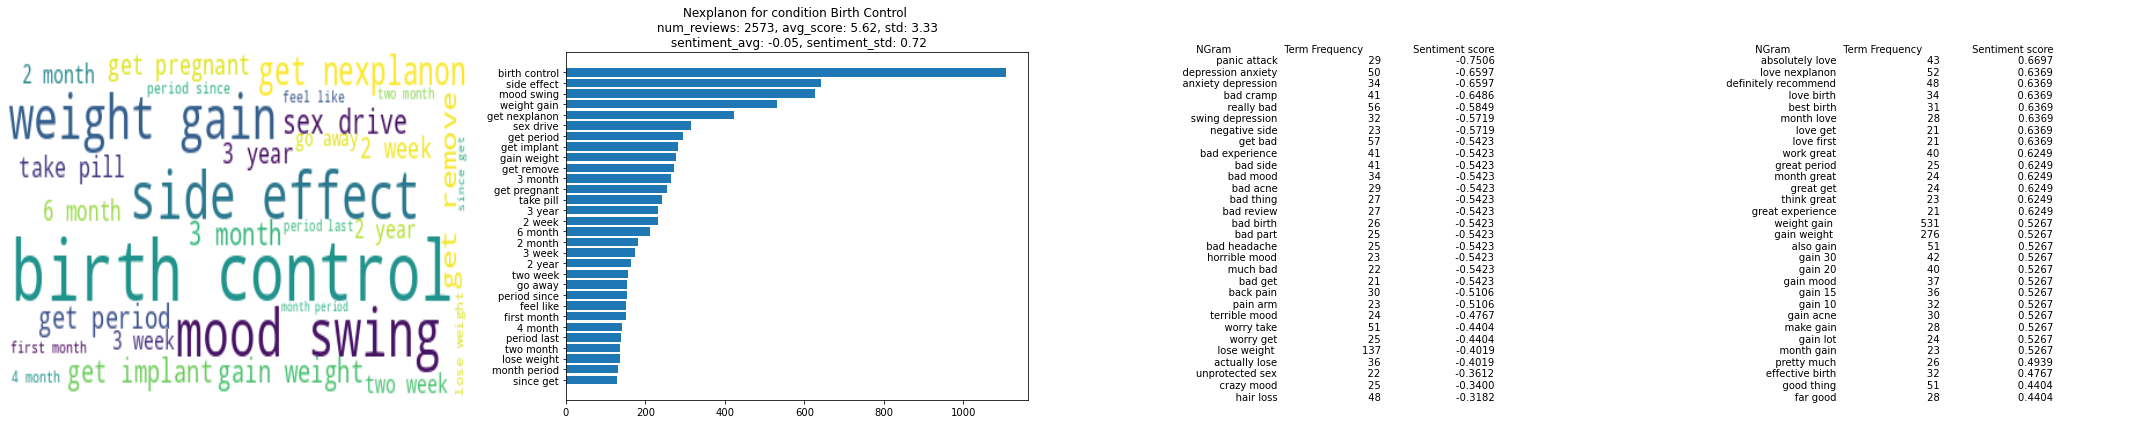

<Figure size 432x288 with 0 Axes>

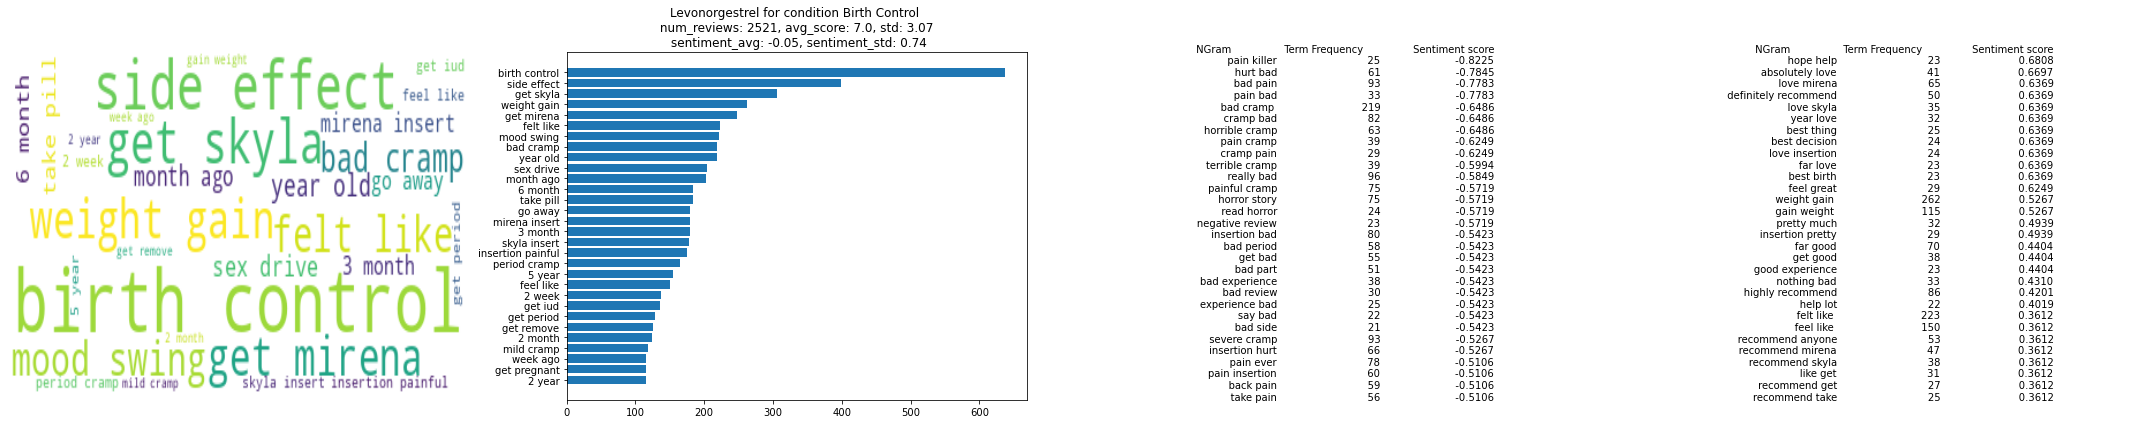

<Figure size 432x288 with 0 Axes>

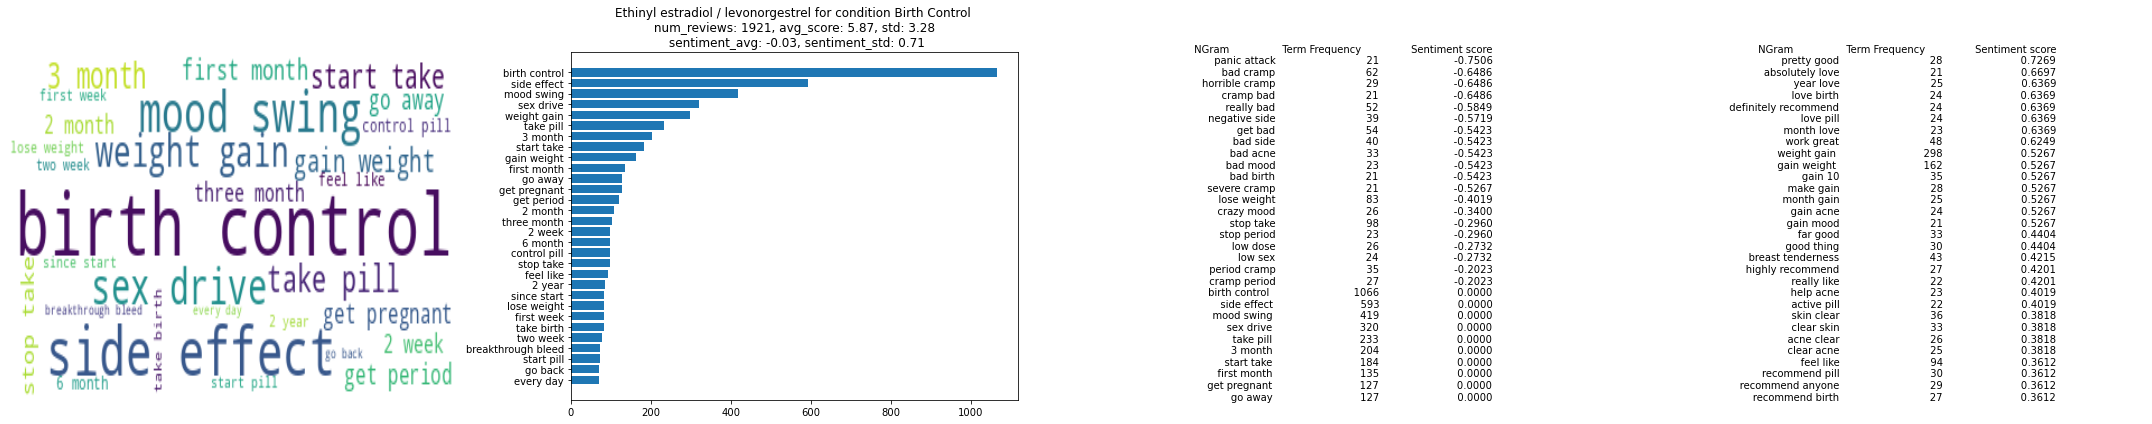

<Figure size 432x288 with 0 Axes>

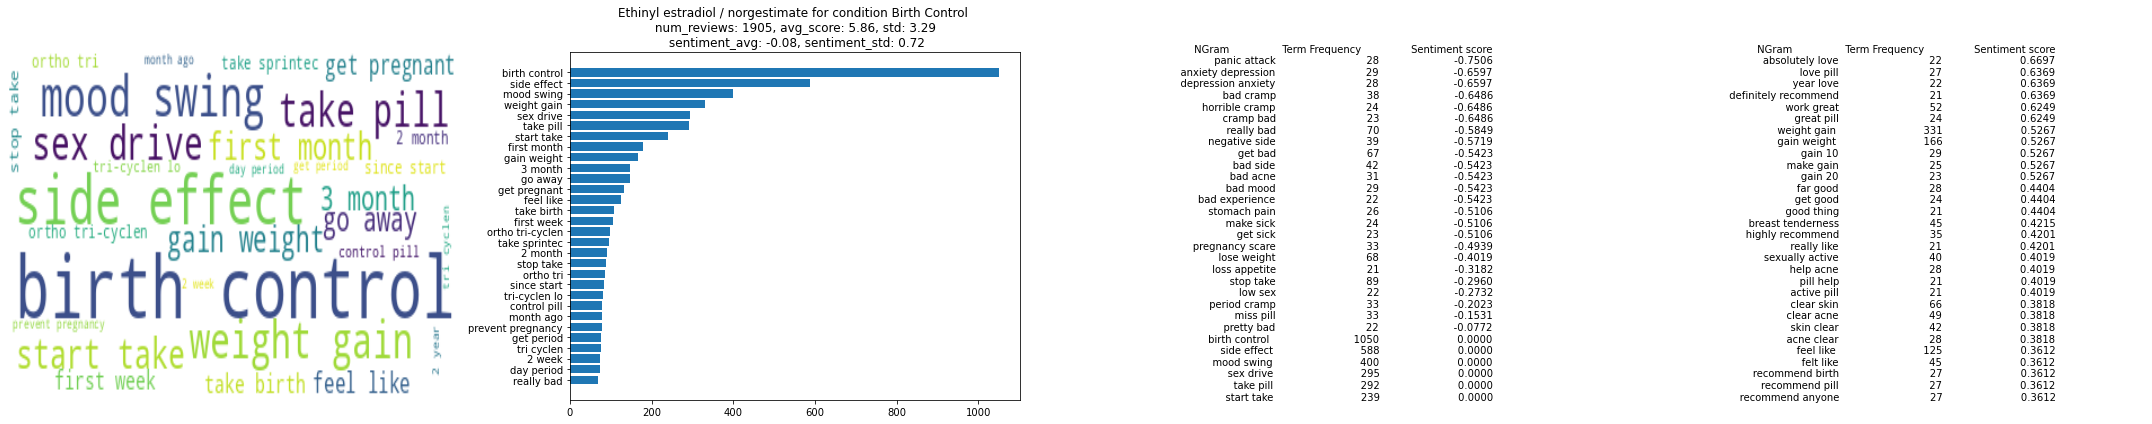

<Figure size 432x288 with 0 Axes>

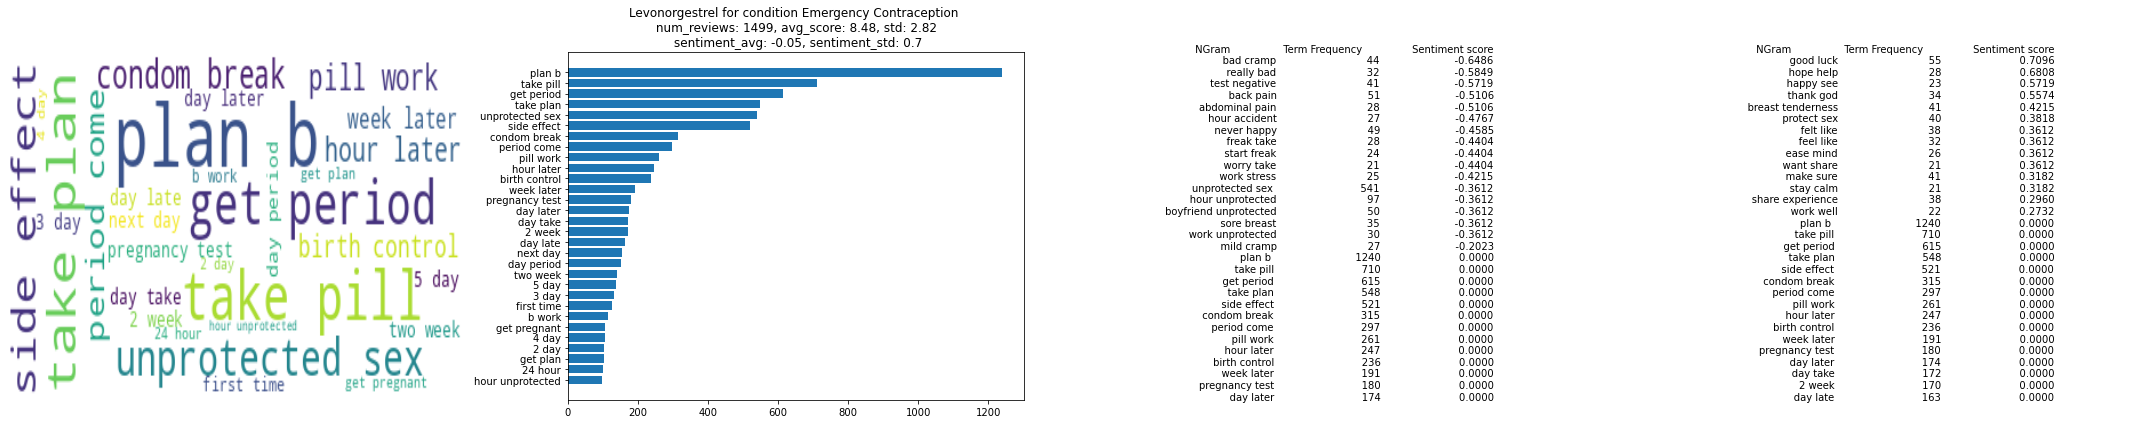

<Figure size 432x288 with 0 Axes>

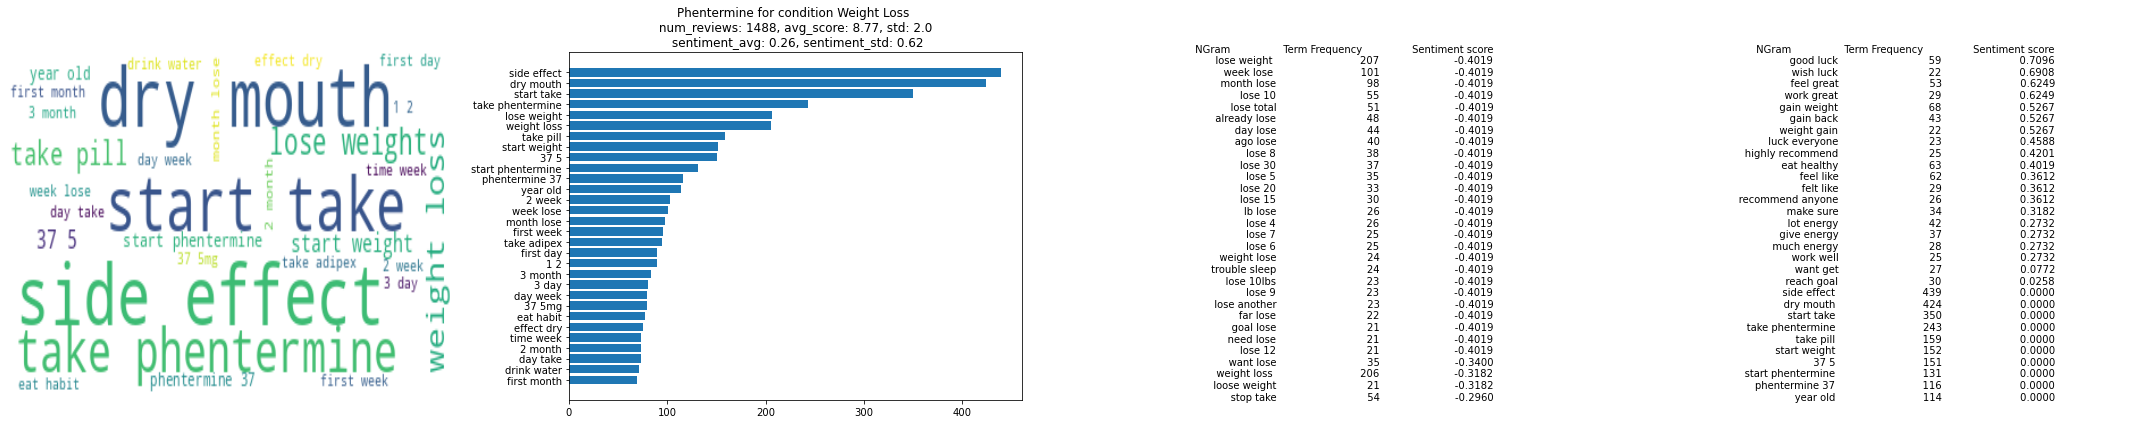

<Figure size 432x288 with 0 Axes>

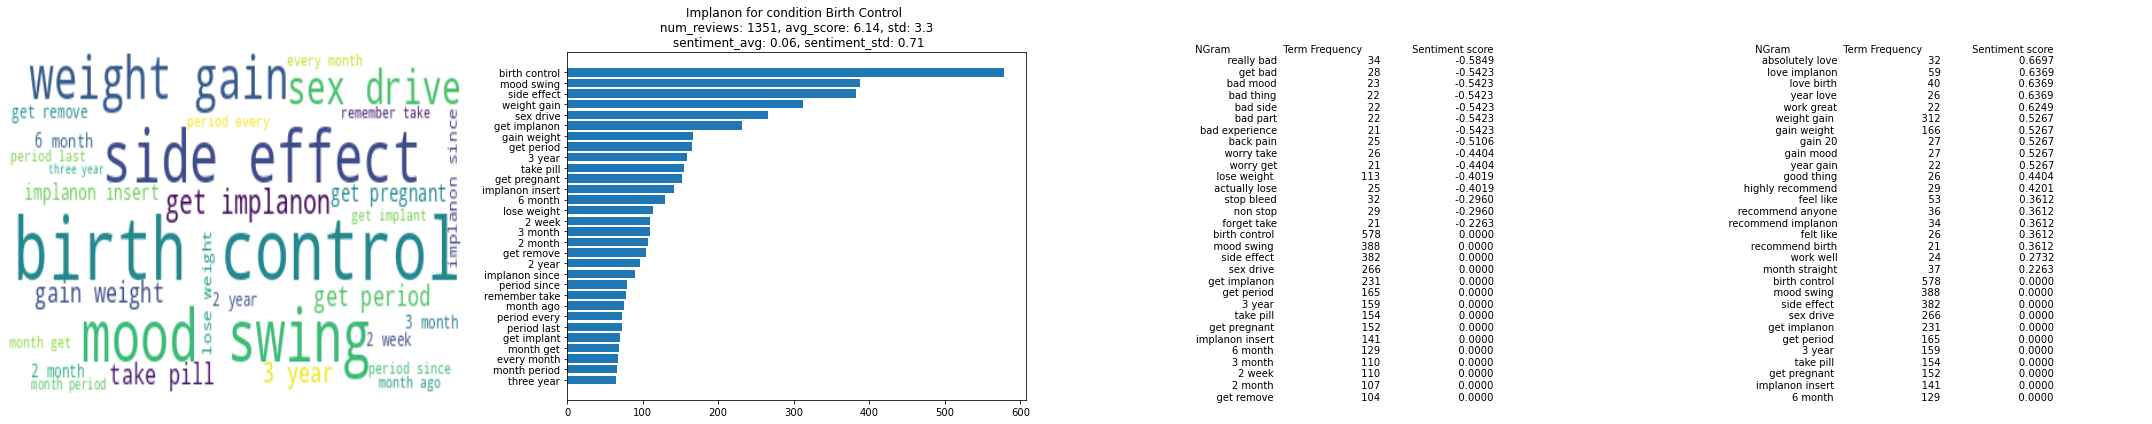

<Figure size 432x288 with 0 Axes>

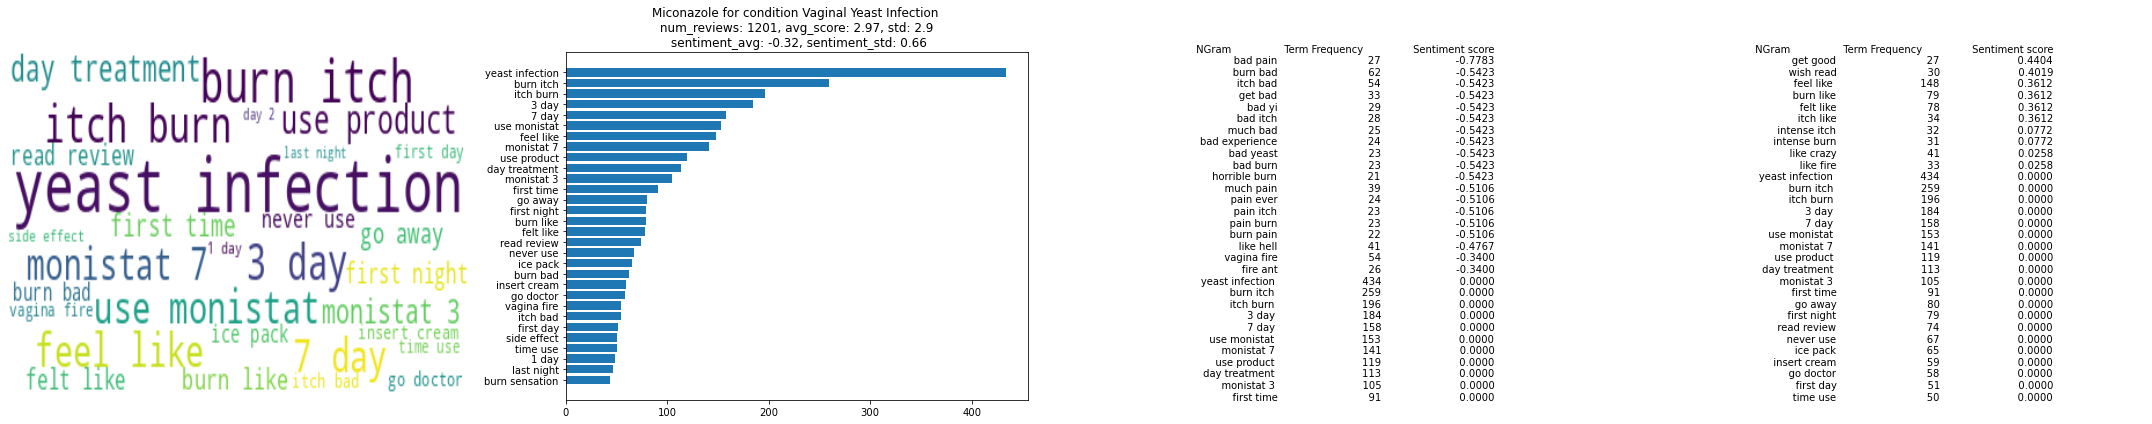

In [91]:
from operator import itemgetter
import pandas as pd


MIN_WORD_FREQ = 20

def generateWordCloud(data):
    for i, pic in enumerate(data):
        
        ## This is for the Text plot
        dt = [(item[0], int(item[1]), float(item[2])) for item in pic["ngram_sentiment_compunds"]] # Since the columns are strings from the spark-dataframe we have to iterate and convert the values to int and float
        dt = list(filter(lambda item: item[1] > MIN_WORD_FREQ, dt)) # Filter out the entries where the word frequency is less than MIN_WORD_FREQ
        
        wordFreqDF = pd.DataFrame(dt, columns=["NGram", "Term Frequency", "Sentiment score"])
        wordFreqSortedNEG = wordFreqDF.sort_values(by=["Sentiment score", "Term Frequency"], ascending=[True, False]) 
        wordFreqSortedPOS = wordFreqDF.sort_values(by=["Sentiment score", "Term Frequency"], ascending=[False, False]) 
        
        ## This is for the wordcloud and bar-plot
        wordFreqDict = dict([(item[0], int(item[1])) for item in pic["ngram_sentiment_compunds"]])
        wordFreqDict = {k: v for k, v in sorted(wordFreqDict.items(), key=lambda item: item[1])}
        review_sentiments = np.array(pic["review_sentiment"]) # Cets the sentiments for each review
        wordcloud = WordCloud(max_font_size=50, max_words=30, repeat=False, background_color="white").fit_words(wordFreqDict)
        plt.figure(i)
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,6))
        # Plot wordcloud
        ax1.imshow(wordcloud, interpolation="bilinear", aspect="auto")
        ax1.axis("off")
        
        # Plot barplot
        ax2.barh(list(wordFreqDict.keys())[-30:], list(wordFreqDict.values())[-30:])
        ax2.set_title("{} for condition {} \n num_reviews: {}, avg_score: {}, std: {} \n sentiment_avg: {}, sentiment_std: {}" \
                      .format(pic["drugName"], pic["condition"], pic["num_reviews"], \
                              round(pic["avg"], 2), round(pic["std"], 2), \
                              round(review_sentiments.mean(),2), round(review_sentiments.std(), 2)))
        
        #Plot the text with sentiment
        ax3.text(0.8,0,wordFreqSortedNEG.head(30).to_string(col_space=30, justify="right", index=False), wrap=False, ha="right")
        ax3.axis("off")
        ax4.text(0.8,0,wordFreqSortedPOS.head(30).to_string(col_space=30, justify="right", index=False), wrap=False, ha="right", transform=ax4.transAxes)
        ax4.axis("off")
        plt.tight_layout()
        plt.show()
        
generateWordCloud(wordFreq)
